# Project Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

In [2]:
# Import advanced ML/NLP/Deep Learning libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    accuracy_score, classification_report, mean_squared_error, r2_score,
    mean_absolute_error
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [3]:
# Deep Learning Imports (Neural Networks and LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [4]:
# --- Configuration ---
RANDOM_STATE = 42
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
tf.random.set_seed(RANDOM_STATE)

In [5]:
# --- Data Loading ---
df = pd.read_csv('climate_nasa.csv')
df['date'] = pd.to_datetime(df['date'])

In [6]:
# --- Data Preprocessing (Handling Missing Values) ---
df['likesCount'].fillna(0, inplace=True)
df['commentsCount'].fillna(df['commentsCount'].median(), inplace=True) # Imputation
df['text'].fillna('', inplace=True)

C:\Users\91960\AppData\Local\Temp\ipykernel_16436\3079972655.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['likesCount'].fillna(0, inplace=True)
C:\Users\91960\AppData\Local\Temp\ipykernel_16436\3079972655.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

In [7]:
# --- Feature Engineering for Models ---
# Target 1: Binary Sentiment (Classification Label)
df['Sentiment_Target'] = df['likesCount'].apply(lambda x: 1 if x >= 5 else 0)

# Target 2: Log-transformed LikesCount (Regression Label)
df['log_likes'] = np.log1p(df['likesCount'])

In [8]:
# Numerical & Linguistic Features
df['text_length'] = df['text'].apply(len)
df['has_question'] = df['text'].apply(lambda x: 1 if '?' in x else 0)
df['has_exclamation'] = df['text'].apply(lambda x: 1 if '!' in x else 0)

In [9]:
# Temporal Features
df['hour_of_day'] = df['date'].dt.hour
df['day_name'] = df['date'].dt.day_name()
df['date_index'] = (df['date'] - df['date'].min()).dt.days # Time index for LSTM

In [10]:
# Text Cleaning
def simple_clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@\w+|[^a-z0-9\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text
df['cleaned_text'] = df['text'].apply(simple_clean_text)

print("Data loaded, missing values handled, and base features created.")

Data loaded, missing values handled, and base features created.


# Data Exploration and Visualization

In [11]:
palette = sns.color_palette("viridis", n_colors=3)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Heuristic_Sentiment'] = df['Sentiment_Target'].map({1: 'High Engagement (1)', 0: 'Low Engagement (0)'})

C:\Users\91960\AppData\Local\Temp\ipykernel_16436\2367193173.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Heuristic_Sentiment', y='log_likes', data=df, palette=palette)
C:\Users\91960\AppData\Local\Temp\ipykernel_16436\2367193173.py:3: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(x='Heuristic_Sentiment', y='log_likes', data=df, palette=palette)


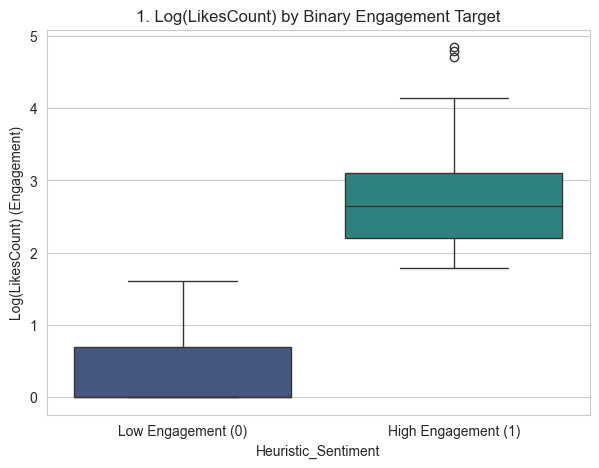

In [12]:
# Plot 1: Engagement vs. Binary Sentiment (BOX PLOT)
plt.figure(figsize=(7, 5))
sns.boxplot(x='Heuristic_Sentiment', y='log_likes', data=df, palette=palette)
plt.title('1. Log(LikesCount) by Binary Engagement Target')
plt.ylabel('Log(LikesCount) (Engagement)')
plt.show()

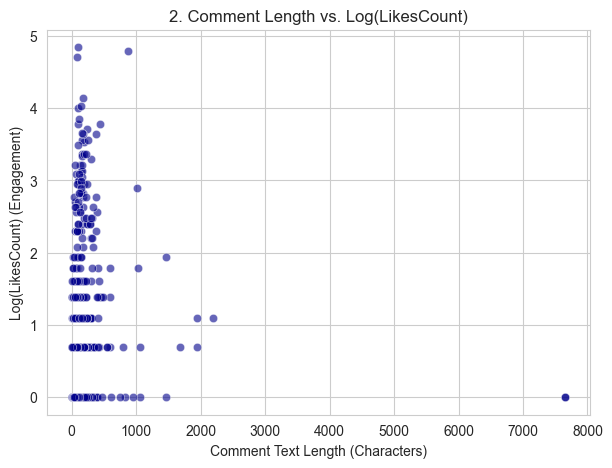

In [13]:
# Plot 2: Engagement vs. Text Length (SCATTER PLOT)
plt.figure(figsize=(7, 5))
sns.scatterplot(x='text_length', y='log_likes', data=df, alpha=0.6, color='darkblue')
plt.title('2. Comment Length vs. Log(LikesCount)')
plt.xlabel('Comment Text Length (Characters)')
plt.ylabel('Log(LikesCount) (Engagement)')
plt.show()

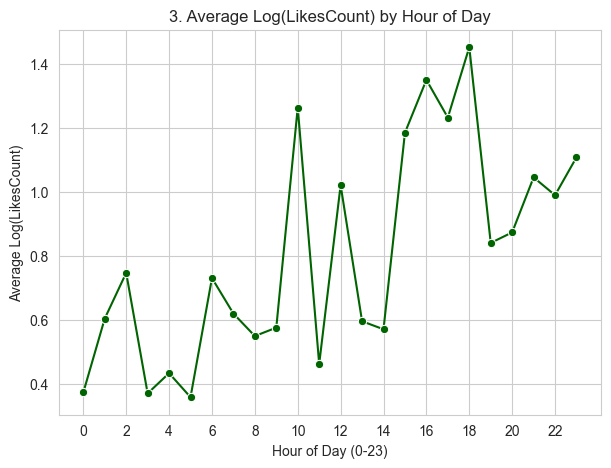

In [14]:
# Plot 3: Engagement vs. Hour of Day (LINE PLOT)
plt.figure(figsize=(7, 5))
hourly_engagement = df.groupby('hour_of_day')['log_likes'].mean()
sns.lineplot(x=hourly_engagement.index, y=hourly_engagement.values, marker='o', color='darkgreen')
plt.title('3. Average Log(LikesCount) by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Average Log(LikesCount)')
plt.xticks(range(0, 24, 2))
plt.show()

C:\Users\91960\AppData\Local\Temp\ipykernel_16436\3389148731.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_engagement.index, y=day_engagement.values, palette='cividis')


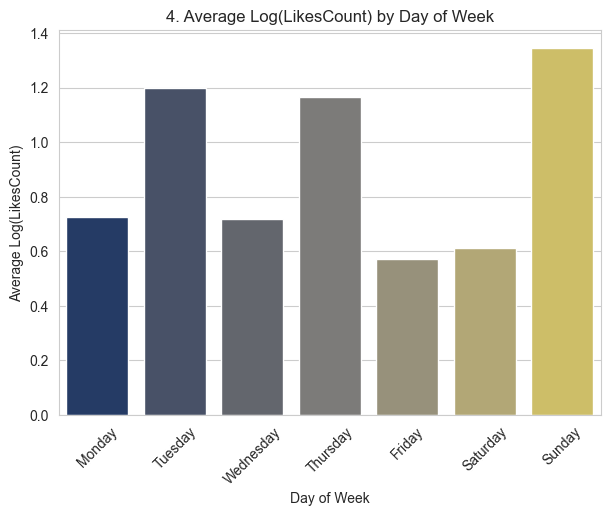

In [15]:
# Plot 4: Engagement vs. Day of Week (BAR PLOT)
plt.figure(figsize=(7, 5))
day_engagement = df.groupby('day_name')['log_likes'].mean().reindex(day_order)
sns.barplot(x=day_engagement.index, y=day_engagement.values, palette='cividis')
plt.title('4. Average Log(LikesCount) by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Log(LikesCount)')
plt.xticks(rotation=45)
plt.show()

C:\Users\91960\AppData\Local\Temp\ipykernel_16436\352115608.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Log_Mean_Likes', data=combined_mean, palette='tab10')


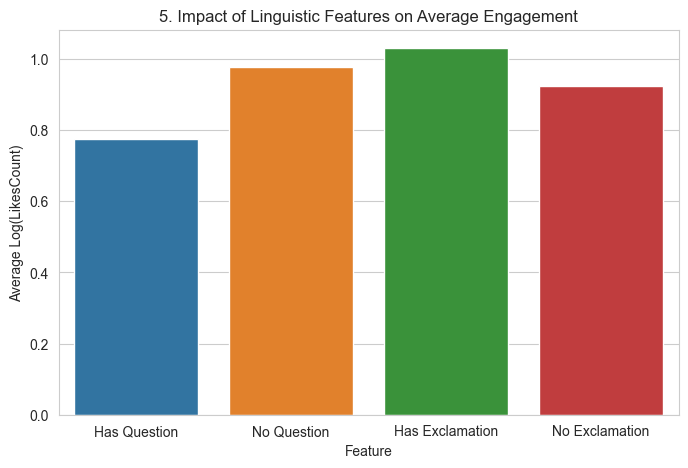

In [16]:
# Plot 5: Impact of Punctuation on Engagement (BAR PLOT)
q_mean = df.groupby('has_question')['log_likes'].mean()
e_mean = df.groupby('has_exclamation')['log_likes'].mean()
combined_mean = pd.DataFrame({
    'Feature': ['Has Question', 'No Question', 'Has Exclamation', 'No Exclamation'],
    'Log_Mean_Likes': [q_mean[1], q_mean[0], e_mean[1], e_mean[0]]
})
plt.figure(figsize=(8, 5))
sns.barplot(x='Feature', y='Log_Mean_Likes', data=combined_mean, palette='tab10')
plt.title('5. Impact of Linguistic Features on Average Engagement')
plt.ylabel('Average Log(LikesCount)')
plt.show()

C:\Users\91960\AppData\Local\Temp\ipykernel_16436\2959934380.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_Target', data=df, palette=['salmon', 'lightgreen'])


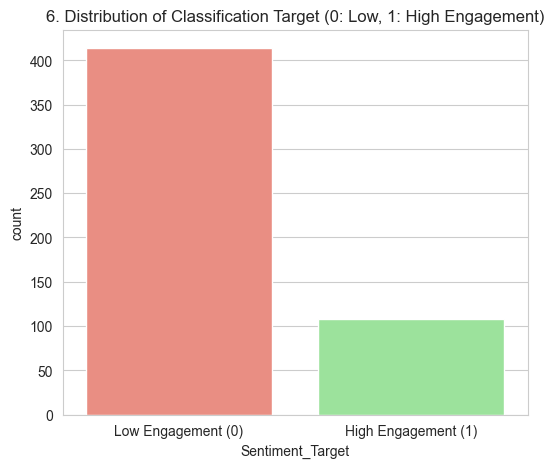

In [17]:
# Plot 6: Distribution of the Classification Target
plt.figure(figsize=(6, 5))
sns.countplot(x='Sentiment_Target', data=df, palette=['salmon', 'lightgreen'])
plt.title('6. Distribution of Classification Target (0: Low, 1: High Engagement)')
plt.xticks([0, 1], ['Low Engagement (0)', 'High Engagement (1)'])
plt.show()

# Feature Engineering

In [18]:
NUM_TOPICS = 5
TOP_WORDS = 8

In [19]:
# 1. TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=500, stop_words='english', min_df=5)
dtm_tfidf = tfidf.fit_transform(df['cleaned_text'])

In [20]:
# 2. Latent Dirichlet Allocation (LDA)
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, random_state=RANDOM_STATE, max_iter=10)
lda.fit(dtm_tfidf)
lda_output = lda.transform(dtm_tfidf)

In [21]:
# 3. Assign Topic Features to DataFrame
topic_cols = [f'Topic_{i+1}_Prob' for i in range(NUM_TOPICS)]
df = pd.concat([df.reset_index(drop=True), pd.DataFrame(lda_output, columns=topic_cols)], axis=1)

In [22]:
# Display Top Words
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-no_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics[f"Topic {topic_idx+1}"] = ", ".join(top_words)
    return topics

tfidf_feature_names = tfidf.get_feature_names_out()
topic_words = display_topics(lda, tfidf_feature_names, TOP_WORDS)

In [23]:
print("\n--- Topic Modeling (LDA) Results ---")
for topic, words in topic_words.items():
    print(f"{topic}: {words}")


--- Topic Modeling (LDA) Results ---
Topic 1: climate, scientists, ice, people, age, heat, earth, lives
Topic 2: global, climate, change, warming, que, warm, years, nasa
Topic 3: going, change, dont, climate, like, just, say, life
Topic 4: need, earth, excellent, good, carbon, water, year, thanks
Topic 5: think, science, thank, know, time, wow, getting, cooling


# Data Preprocessing

In [24]:
# Define all feature sets
TOPIC_FEATURES = [col for col in df.columns if 'Topic_' in col]
NUMERICAL_FEATURES = ['commentsCount', 'text_length', 'has_question', 'has_exclamation', 'hour_of_day', 'date_index']
CATEGORICAL_FEATURES = ['day_name']

X_structured = df[NUMERICAL_FEATURES + CATEGORICAL_FEATURES + TOPIC_FEATURES].copy()

In [25]:
# 1. Preprocessing Pipeline (Standardize & One-Hot Encode)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERICAL_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES),
        ('topic', 'passthrough', TOPIC_FEATURES)
    ]
)

In [26]:
# Fit and Transform the data
X_processed = preprocessor.fit_transform(X_structured)

In [27]:
# Get feature names
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(CATEGORICAL_FEATURES)
final_feature_names = [f for f in NUMERICAL_FEATURES if f not in CATEGORICAL_FEATURES] + list(cat_feature_names) + TOPIC_FEATURES
X_final = pd.DataFrame(X_processed, columns=final_feature_names)

In [28]:
# 2. Split Data (Training and Testing Sets)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_final, df[['Sentiment_Target', 'log_likes']], test_size=0.2, random_state=RANDOM_STATE
)

In [29]:
# Splitting Targets
y_C_train, y_C_test = y_train_full['Sentiment_Target'], y_test['Sentiment_Target']
y_R_train, y_R_test = y_train_full['log_likes'], y_test['log_likes']

In [30]:
# Prepare LSTM input: Reshaping X to [samples, time steps, features]
X_train_lstm = np.reshape(X_train_full.values, (X_train_full.shape[0], 1, X_train_full.shape[1]))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

# Model Selection , Training and Evaluation(Classification)

In [31]:
# 1. Decision Tree Classifier
dt_clf = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE)
dt_clf.fit(X_train_full, y_C_train)

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [32]:
# 2. Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, class_weight='balanced')
rf_clf.fit(X_train_full, y_C_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [33]:
y_pred_dt_C = dt_clf.predict(X_test)
y_pred_rf_C = rf_clf.predict(X_test)

In [34]:
def get_classification_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Avg)': report['weighted avg']['precision'],
        'Recall (Avg)': report['weighted avg']['recall'],
        'F1-Score (Avg)': report['weighted avg']['f1-score'],
    }

In [35]:
dt_metrics = get_classification_metrics(y_C_test, y_pred_dt_C, "Decision Tree")
rf_metrics = get_classification_metrics(y_C_test, y_pred_rf_C, "Random Forest")
classification_results = pd.DataFrame([dt_metrics, rf_metrics])

In [36]:
print("\n--- Model Evaluation: Sentiment Classification ---")
print(classification_results.set_index('Model').T.round(4))


--- Model Evaluation: Sentiment Classification ---
Model            Decision Tree  Random Forest
Accuracy                0.7810         0.8476
Precision (Avg)         0.7851         0.8321
Recall (Avg)            0.7810         0.8476
F1-Score (Avg)          0.7830         0.8265


C:\Users\91960\AppData\Local\Temp\ipykernel_16436\3281688987.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis')


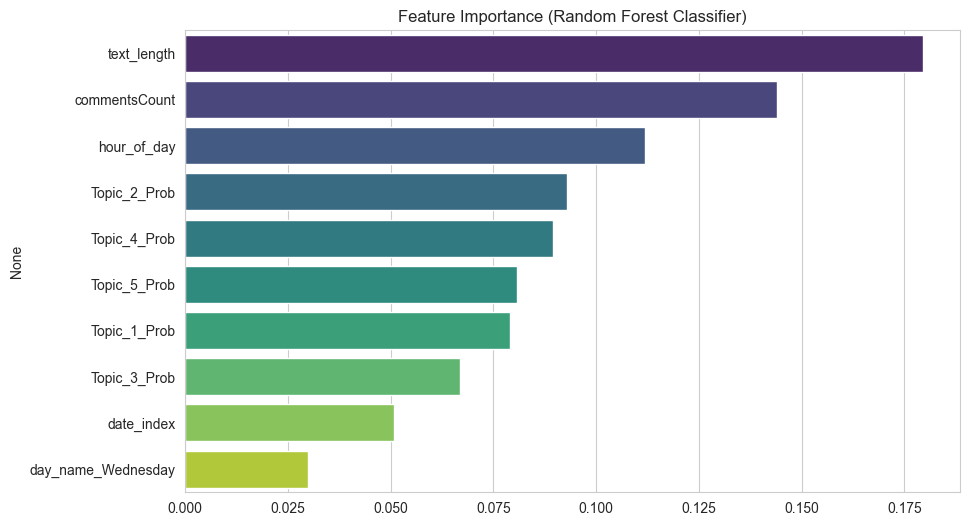

In [37]:
# Visualize Feature Importance for Random Forest
plt.figure(figsize=(10, 6))
importances = rf_clf.feature_importances_
feature_series = pd.Series(importances, index=X_final.columns)
top_10_features = feature_series.nlargest(10)
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis')
plt.title('Feature Importance (Random Forest Classifier)')
plt.show()

# Regression Model and Evaluation

In [38]:
# 1. Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_full, y_R_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [39]:
# 2. Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
gbr.fit(X_train_full, y_R_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [40]:
# 1. Neural Network (MLP) Model
def build_mlp_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

mlp_model = build_mlp_model(X_train_full.shape[1])
mlp_model.fit(X_train_full, y_R_train, epochs=10, batch_size=32, verbose=0)

C:\Users\91960\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
# 2. Long Short-Term Memory (LSTM) Model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = build_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
lstm_model.fit(X_train_lstm, y_R_train, epochs=10, batch_size=32, verbose=0)

C:\Users\91960\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Regression Model Evaluation 

In [42]:
# Predictions
y_pred_lin_R = lin_reg.predict(X_test)
y_pred_gbr_R = gbr.predict(X_test)
y_pred_mlp_R = mlp_model.predict(X_test, verbose=0).flatten()
y_pred_lstm_R = lstm_model.predict(X_test_lstm, verbose=0).flatten()

In [43]:
# Convert all predictions back to original scale (LikesCount)
y_R_test_orig = np.expm1(y_R_test)

def expm1_predict(y_pred):
    return np.maximum(np.expm1(y_pred), 0)

y_pred_lin_R_orig = expm1_predict(y_pred_lin_R)
y_pred_gbr_R_orig = expm1_predict(y_pred_gbr_R)
y_pred_mlp_R_orig = expm1_predict(y_pred_mlp_R)
y_pred_lstm_R_orig = expm1_predict(y_pred_lstm_R)

In [44]:
# Collect Evaluation Metrics (MAE, MSE, RMSE, R-squared)
def get_regression_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    return {
        'Model': model_name,
        'R-squared': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mse,
        'RMSE': np.sqrt(mse)
    }

In [45]:
lin_metrics = get_regression_metrics(y_R_test_orig, y_pred_lin_R_orig, "Linear Regression")
gbr_metrics = get_regression_metrics(y_R_test_orig, y_pred_gbr_R_orig, "Gradient Boosting")
mlp_metrics = get_regression_metrics(y_R_test_orig, y_pred_mlp_R_orig, "Neural Network (MLP)")
lstm_metrics = get_regression_metrics(y_R_test_orig, y_pred_lstm_R_orig, "LSTM Network")

In [46]:
regression_results = pd.DataFrame([lin_metrics, gbr_metrics, mlp_metrics, lstm_metrics])

In [47]:
print("\n--- Model Evaluation: Engagement Regression (4 Models) ---")
print(regression_results.set_index('Model').T.round(4))


--- Model Evaluation: Engagement Regression (4 Models) ---
Model      Linear Regression  Gradient Boosting  Neural Network (MLP)  \
R-squared             0.0246             0.0476                0.0091   
MAE                   4.0169             4.0475                4.2271   
MSE                 175.2553           171.1160              178.0418   
RMSE                 13.2384            13.0811               13.3432   

Model      LSTM Network  
R-squared        0.0184  
MAE              4.1566  
MSE            176.3684  
RMSE            13.2804  


In [48]:
# Visualize Performance (Predicted vs. Actual and Residuals) for the best model (Gradient Boosting)
best_model_predictions = y_pred_gbr_R_orig
residuals = y_R_test_orig - best_model_predictions

In [49]:
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

Text(0, 0.5, 'Predicted LikesCount')

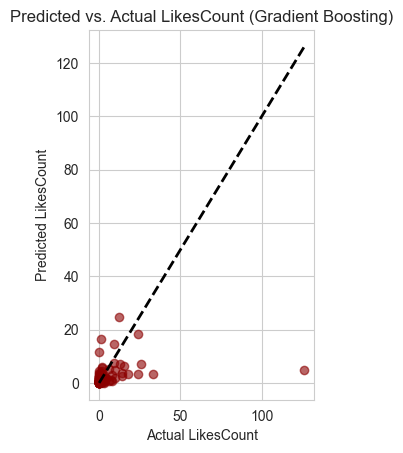

In [50]:
# Subplot 1: Predicted vs. Actual Plot
plt.subplot(1, 2, 1)
plt.scatter(y_R_test_orig, best_model_predictions, alpha=0.6, color='darkred')
plt.plot([0, max(y_R_test_orig)], [0, max(y_R_test_orig)], 'k--', lw=2)
plt.title('Predicted vs. Actual LikesCount (Gradient Boosting)')
plt.xlabel('Actual LikesCount')
plt.ylabel('Predicted LikesCount')

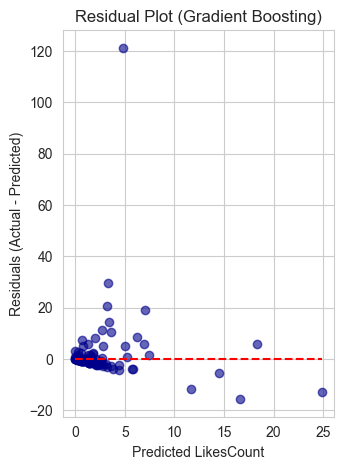

In [51]:
# Subplot 2: Residual Plot
plt.subplot(1, 2, 2)
plt.scatter(best_model_predictions, residuals, alpha=0.6, color='darkblue')
plt.hlines(0, xmin=min(best_model_predictions), xmax=max(best_model_predictions), color='red', linestyles='--')
plt.title('Residual Plot (Gradient Boosting)')
plt.xlabel('Predicted LikesCount')
plt.ylabel('Residuals (Actual - Predicted)')

plt.tight_layout()
plt.show()

# Model saving

In [52]:
# Save the critical NLP components (TFIDF and LDA)
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')  
joblib.dump(lda, 'lda_model.pkl')            

# Save the Machine Learning models and the full preprocessing pipeline (ColumnTransformer)
joblib.dump(rf_clf, 'rf_sentiment_classifier.pkl')
joblib.dump(gbr, 'gbr_engagement_regressor.pkl')
joblib.dump(preprocessor, 'full_preprocessor_pipeline.pkl')

# Save Keras Deep Learning models (MLP and LSTM)
mlp_model.save('mlp_engagement_regressor.keras')
lstm_model.save('lstm_engagement_regressor.keras')